# Sanity Checks for Quantum Bayesian Learner

This notebook performs comprehensive sanity checks on all components of the quantum Bayesian learner system.

## Overview

We verify:
1. Environment setup and imports
2. Dataset loading and structure
3. Evidence channel construction and CPTP properties
4. Density matrix updates
5. Ansatz construction
6. Forward pass computation
7. Circuit transpilation


## 1. Environment Check

Import all required libraries and project modules. Verify versions are compatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.quantum_info import DensityMatrix, Operator
from qiskit.visualization import plot_bloch_multivector

# Import project modules
import sys
sys.path.insert(0, '..')
from src.data import get_toy_dataset
from src.channels import evidence_kraus, apply_channel_to_density_matrix, debug_channel
from src.ansatz import build_ansatz, count_parameters, init_random_theta, init_full_mask, get_default_pairs
from src.learner import forward_loss, predict_proba, set_seed
from src.transpile_utils import transpile_and_count_2q

# Print versions
print("=" * 60)
print("Environment Check")
print("=" * 60)
print(f"NumPy version: {np.__version__}")
print(f"Qiskit version: {qiskit.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print("=" * 60)
print("✓ All imports successful!")


Environment Check
NumPy version: 2.3.5
Qiskit version: 2.2.3
Matplotlib version: 3.10.7
✓ All imports successful!


## 2. Dataset Check

Load the toy dataset and examine its structure. Verify data shapes and visualize samples.


Dataset Check
Dataset shape: X=(8, 2), y=(8,)
Number of samples: 8
Number of features: 2
Label distribution: [4 4]

First 5 samples:
Features (X):
[[0.27419089 0.30751327]
 [0.2731306  0.15877899]
 [0.31337491 0.28124622]
 [0.21241327 0.29067827]
 [0.76323374 0.71340761]]

Labels (y):
[0 0 0 0 1]


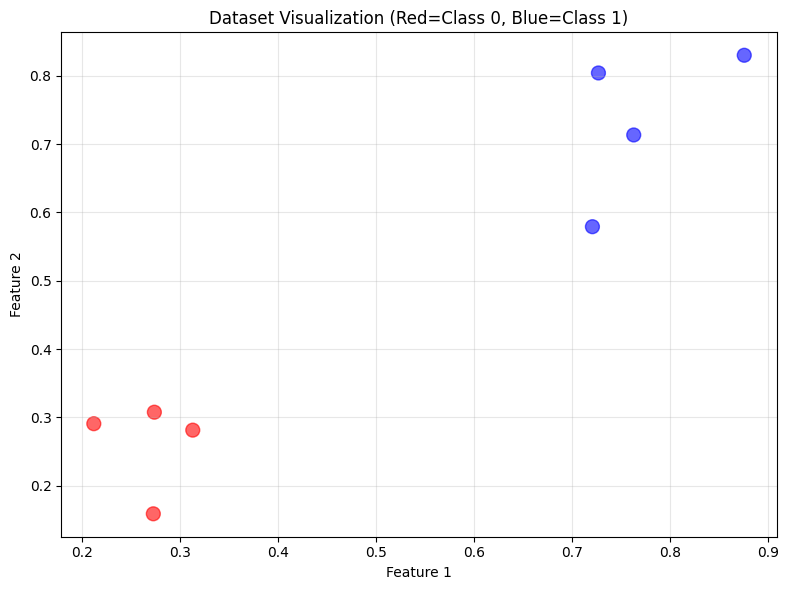

✓ Dataset check complete!


In [3]:
# Load dataset
X, y = get_toy_dataset(name="pothos_chater_small")

print("=" * 60)
print("Dataset Check")
print("=" * 60)
print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Label distribution: {np.bincount(y)}")
print("\nFirst 5 samples:")
print("Features (X):")
print(X[:5])
print("\nLabels (y):")
print(y[:5])

# Visualize dataset
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = ['red' if label == 0 else 'blue' for label in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6, s=100)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Dataset Visualization (Red=Class 0, Blue=Class 1)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("✓ Dataset check complete!")


## 3. Evidence Channel Check

Build evidence channels for different stimuli and verify:
- Kraus operator structure
- Operator norms
- CPTP condition: Σ_k K_k† K_k = I


In [4]:
# Test stimuli
test_stimuli = [
    np.array([0.0, 0.0, 0.0]),
    np.array([1.0, 1.0, 1.0]),
    np.array([0.5, 0.5, 0.5]),
    np.array([0.2, 0.8, 0.3]),
]

print("=" * 60)
print("Evidence Channel Check")
print("=" * 60)

for i, x in enumerate(test_stimuli):
    print(f"\n--- Stimulus {i+1}: {x} ---")
    
    # Build channel
    channel = evidence_kraus(x, strength=0.4)
    
    # Get Kraus operators
    kraus_ops = channel.data
    
    print(f"Number of Kraus operators: {len(kraus_ops)}")
    print(f"Kraus operator shapes: {[K.shape for K in kraus_ops]}")
    
    # Compute operator norms
    norms = [np.linalg.norm(K, ord=2) for K in kraus_ops]
    print(f"Operator norms: {norms}")
    
    # Verify CPTP condition: Σ_k K_k† K_k = I
    identity = np.eye(2, dtype=complex)
    completeness = sum(K.conj().T @ K for K in kraus_ops)
    error = np.linalg.norm(completeness - identity)
    
    print(f"CPTP completeness error: {error:.2e}")
    print(f"CPTP condition satisfied: {error < 1e-10}")
    
    # Debug channel
    print("\nChannel debug info:")
    debug_channel(channel)

print("\n" + "=" * 60)
print("✓ Evidence channel check complete!")


Evidence Channel Check

--- Stimulus 1: [0. 0. 0.] ---
Number of Kraus operators: 2
Kraus operator shapes: [(2, 2), (2, 2)]
Operator norms: [np.float64(1.0), np.float64(0.31622776601683794)]
CPTP completeness error: 1.11e-16
CPTP condition satisfied: True

Channel debug info:
Channel Debug Information

Number of Kraus operators: 2

Kraus operator shapes:
  K0: (2, 2)
    [[1.       +0.j 0.       +0.j]
 [0.       +0.j 0.9486833+0.j]]
  K1: (2, 2)
    [[0.        +0.j 0.31622777+0.j]
 [0.        +0.j 0.        +0.j]]

CPTP Check (sum_i K_i^dagger @ K_i should equal I):
  Max deviation from identity: 1.11e-16
  ✓ Channel is CPTP (within tolerance)

Trace Preservation Check:
  Test state 1: trace before=1.000000+0.000000j, after=1.000000+0.000000j, diff=0.00e+00
  Test state 2: trace before=1.000000+0.000000j, after=1.000000+0.000000j, diff=0.00e+00
  Test state 3: trace before=1.000000+0.000000j, after=1.000000+0.000000j, diff=1.11e-16

--- Stimulus 2: [1. 1. 1.] ---
Number of Kraus opera

## 4. Density Matrix Update Check

Create a maximally mixed state, apply an evidence channel, and verify:
- Positivity (all eigenvalues ≥ 0)
- Trace preservation (trace = 1)
- Physical validity


In [5]:
# Create maximally mixed state
rho_initial = DensityMatrix.from_label('+')  # |+⟩ state
print("=" * 60)
print("Density Matrix Update Check")
print("=" * 60)
print("\nInitial state (|+⟩):")
print(rho_initial.data)
print(f"Trace: {np.trace(rho_initial.data):.6f}")
print(f"Eigenvalues: {np.linalg.eigvals(rho_initial.data)}")

# Apply evidence channel
x = np.array([0.5, 0.5, 0.5])
channel = evidence_kraus(x, strength=0.4)
rho_updated = apply_channel_to_density_matrix(rho_initial, channel)

print("\nAfter applying evidence channel:")
print(rho_updated.data)
print(f"Trace: {np.trace(rho_updated.data):.6f}")
print(f"Eigenvalues: {np.linalg.eigvals(rho_updated.data)}")

# Verify properties
trace_ok = abs(np.trace(rho_updated.data) - 1.0) < 1e-10
eigenvals = np.linalg.eigvals(rho_updated.data)
positivity_ok = np.all(eigenvals >= -1e-10)  # Allow small numerical errors
hermiticity_ok = np.allclose(rho_updated.data, rho_updated.data.conj().T)

print("\nVerification:")
print(f"  Trace = 1: {trace_ok}")
print(f"  Positivity (eigenvalues ≥ 0): {positivity_ok}")
print(f"  Hermiticity: {hermiticity_ok}")
print(f"  All checks passed: {trace_ok and positivity_ok and hermiticity_ok}")

print("\n" + "=" * 60)
print("✓ Density matrix update check complete!")


Density Matrix Update Check

Initial state (|+⟩):
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]
Trace: 1.000000+0.000000j
Eigenvalues: [ 1.00000000e+00+0.0000000e+00j -8.71576399e-33-5.4495556e-81j]

After applying evidence channel:
[[0.6      +0.j 0.4472136+0.j]
 [0.4472136+0.j 0.4      +0.j]]
Trace: 1.000000+0.000000j
Eigenvalues: [0.95825757+0.j 0.04174243+0.j]

Verification:
  Trace = 1: True
  Positivity (eigenvalues ≥ 0): True
  Hermiticity: True
  All checks passed: True

✓ Density matrix update check complete!


## 5. Ansatz Construction Test

Build a small ansatz circuit and verify:
- Circuit structure
- Parameter count
- Circuit validity


In [ ]:
# Build ansatz
n_qubits = 2
depth = 3
pairs = get_default_pairs(n_qubits)

# Initialize parameters
theta = init_random_theta(n_qubits, depth, len(pairs), scale=0.1, seed=42)
mask = init_full_mask(depth, len(pairs))

print("=" * 60)
print("Ansatz Construction Test")
print("=" * 60)
print(f"n_qubits: {n_qubits}")
print(f"depth: {depth}")
print(f"pairs: {pairs}")
print(f"theta shape: {theta.shape}")
print(f"mask shape: {mask.shape}")

# Build circuit
ansatz = build_ansatz(
    n_qubits=n_qubits,
    depth=depth,
    theta=theta,
    mask=mask,
    pairs=pairs
)

print(f"\nCircuit:")
print(ansatz)
print(f"\nCircuit depth: {ansatz.depth()}")
print(f"Number of gates: {len(ansatz.data)}")

# Count parameters
n_params = count_parameters(theta, mask)
print(f"\nTotal parameters: {n_params}")

# Draw circuit (using text output to avoid pylatexenc dependency)
print("\nCircuit visualization:")
try:
    # Try matplotlib first (requires pylatexenc)
    from qiskit.visualization import circuit_drawer
    display(ansatz.draw(output='mpl', style='clifford'))
except Exception as e:
    # Fall back to text output if matplotlib fails
    print("Note: Using text output (install 'pylatexenc' for matplotlib visualization)")
    print(ansatz.draw(output='text', style='clifford'))

print("\n" + "=" * 60)
print("✓ Ansatz construction check complete!")


Ansatz Construction Test
n_qubits: 2
depth: 3
pairs: [(0, 1)]
theta shape: (3, 2, 5)
mask shape: (3, 1)

Circuit:
     ┌──────────────┐ ┌────────────┐ ┌────────────────┐┌────────────────┐»
q_0: ┤ Rx(0.030472) ├─┤ Rz(-0.104) ├─┤0               ├┤0               ├»
     ├──────────────┤┌┴────────────┴┐│  Rxx(0.075045) ││  Ryy(0.094056) │»
q_1: ┤ Rx(-0.13022) ├┤ Rz(0.012784) ├┤1               ├┤1               ├»
     └──────────────┘└──────────────┘└────────────────┘└────────────────┘»
«                    ┌─────────────┐ ┌──────────────┐┌─────────────────┐»
«q_0: ─■─────────────┤ Rx(0.08794) ├─┤ Rz(0.077779) ├┤0                ├»
«      │ZZ(-0.1951) ┌┴─────────────┴┐├──────────────┤│  Rxx(0.0066031) │»
«q_1: ─■────────────┤ Rx(-0.085929) ├┤ Rz(0.036875) ├┤1                ├»
«                   └───────────────┘└──────────────┘└─────────────────┘»
«     ┌───────────────┐               ┌───────────────┐┌───────────────┐»
«q_0: ┤0              ├─■─────────────┤ Rx(-0.018486) ├┤ Rz(-0.0680

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

## 6. Forward Pass Test

Run a complete forward pass through the learner and verify:
- Loss computation
- Prediction generation
- Gate counting


In [ ]:
# Set seed for reproducibility
set_seed(42)

# Load small dataset
X, y = get_toy_dataset(name="pothos_chater_small")

# Build ansatz
n_qubits = 2
depth = 3
pairs = get_default_pairs(n_qubits)
theta = init_random_theta(n_qubits, depth, len(pairs), scale=0.1, seed=42)
mask = init_full_mask(depth, len(pairs))

print("=" * 60)
print("Forward Pass Test")
print("=" * 60)
print(f"Dataset: {X.shape[0]} samples")
print(f"Parameters: theta shape {theta.shape}, mask shape {mask.shape}")

# Run forward loss
result = forward_loss(
    theta=theta,
    mask=mask,
    X=X,
    y=y,
    lam=0.1,
    pairs=pairs,
    backend=None,
    n_qubits=n_qubits,
    depth=depth,
    channel_strength=0.4,
)

print("\nForward pass results:")
print(f"  Total loss: {result['total_loss']:.6f}")
print(f"  CE loss: {result['ce_loss']:.6f}")
print(f"  2-qubit gate count: {result['two_q_cost']}")
print(f"  Average prediction: {result['avg_pred']:.4f}")
print(f"  Predictions shape: {result['preds'].shape}")
print(f"  Predictions range: [{result['preds'].min():.4f}, {result['preds'].max():.4f}]")

# Check predictions
print(f"\nFirst 5 predictions: {result['preds'][:5]}")
print(f"First 5 true labels: {y[:5]}")

print("\n" + "=" * 60)
print("✓ Forward pass check complete!")


## 7. Transpilation Check

Transpile the circuit and compare gate counts before and after transpilation.


In [ ]:
# Build ansatz
n_qubits = 2
depth = 3
pairs = get_default_pairs(n_qubits)
theta = init_random_theta(n_qubits, depth, len(pairs), scale=0.1, seed=42)
mask = init_full_mask(depth, len(pairs))

ansatz = build_ansatz(
    n_qubits=n_qubits,
    depth=depth,
    theta=theta,
    mask=mask,
    pairs=pairs
)

print("=" * 60)
print("Transpilation Check")
print("=" * 60)

# Count gates before transpilation
print("\nBefore transpilation:")
print(f"  Circuit depth: {ansatz.depth()}")
print(f"  Total gates: {len(ansatz.data)}")
twoq_before = sum(1 for inst in ansatz.data if len(inst.qubits) == 2)
oneq_before = sum(1 for inst in ansatz.data if len(inst.qubits) == 1)
print(f"  1-qubit gates: {oneq_before}")
print(f"  2-qubit gates: {twoq_before}")

# Transpile and count
transpiled_result = transpile_and_count_2q(ansatz, backend=None)
transpiled_circuit = transpiled_result["circuit"]
twoq_after = transpiled_result["n_2q"]
oneq_after = transpiled_result["n_1q"]
depth_after = transpiled_result["depth"]

print("\nAfter transpilation:")
print(f"  Circuit depth: {depth_after}")
print(f"  1-qubit gates: {oneq_after}")
print(f"  2-qubit gates: {twoq_after}")

print("\nComparison:")
print(f"  2-qubit gates: {twoq_before} → {twoq_after} (change: {twoq_after - twoq_before:+d})")
print(f"  1-qubit gates: {oneq_before} → {oneq_after} (change: {oneq_after - oneq_before:+d})")
print(f"  Depth: {ansatz.depth()} → {depth_after} (change: {depth_after - ansatz.depth():+d})")

# Visualize both circuits
print("\nOriginal circuit:")
try:
    display(ansatz.draw(output='mpl', style='clifford'))
except Exception:
    print("Using text output:")
    print(ansatz.draw(output='text', style='clifford'))

print("\nTranspiled circuit:")
try:
    display(transpiled_circuit.draw(output='mpl', style='clifford'))
except Exception:
    print("Using text output:")
    print(transpiled_circuit.draw(output='text', style='clifford'))

print("\n" + "=" * 60)
print("✓ Transpilation check complete!")
